In [1]:
#IMPORT NECESSARY PACKAGES
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymysql.cursors
import datetime
import matplotlib.gridspec as grd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime
from time import mktime

In [2]:
#Ask the user for the date range between which data will be pulled from SQL
def get_date_range():
    date1=input("Enter Start Date YYYY-mm-DD: ")
    date2=input("Enter End Date YYYY-mm-DD: ")
    return date1,date2

In [3]:
def sql_connect():
    #Connect to SQL database with username and pw
    mydb = pymysql.connect(
        host='155.98.6.253',
        user='EddyFlux',
        passwd = 'UvTrhM_yFo71X2',
        database = 'CO2_Eddy'
        )
    
    #Set up cursor (allows navigation through SQL syntax)
    mycursor = mydb.cursor()
    
    return mycursor

In [4]:
def get_LI_data(tablename,date1,date2):
    ######################################################################
    # Function to get exclusively "Spike Necessary" LI_8100 Data         # 
    # from SQL. Input the SQL Tablename, and date range between which    #
    # data will be fetched. For one day's worth of data, enter the same  #
    # Date.                                                              #
    ######################################################################
    
    mycursor = sql_connect()
    mycursor.execute("SELECT Local_DT, EPOCH_TIME, Cdry\
                        FROM {}\
                        WHERE Local_DT >= '{} 00:00:00' AND Local_DT <= '{} 23:59:59.99'\
                        order by EPOCH_TIME asc;".format(tablename,date1,date2)) #SQL statement
    data = mycursor.fetchall() #fetch the data
    LI_vent = pd.DataFrame(list(data)) #convert imported data to dataframe
    LI_vent.columns = ['Local_DT','EPOCH_TIME','CO2'] #name columns
    cols = LI_vent.columns.drop('Local_DT') #get all column names beside date column
    LI_vent[cols]=LI_vent[cols].apply(pd.to_numeric,errors='coerce') #change all but date to floats
    
    return LI_vent

In [5]:
def get_vent_anem_temp_data(tablename,date1,date2):
    ######################################################################
    # Function to get exclusively "Spike Necessary" Vent_Anem_Temp Data  # 
    # from SQL. Input the SQL Tablename, and date range between which    #
    # data will be fetched. For one day's worth of data, enter the same  #
    # Date.                                                              #
    ######################################################################
    
    #Connect to SQL
    mycursor = sql_connect()
    mycursor.execute("SELECT *\
                    FROM {}\
                    WHERE Local_DT >= '{} 00:00:00' AND Local_DT <= '{} 23:59:59.99'\
                    order by EPOCH_TIME asc;".format(tablename,date1,date2)) #SQL query
    data = mycursor.fetchall() #fetch the data
    Vent_Anem_Temp = pd.DataFrame(list(data)) #convert imported data to a dataframe
    Vent_Anem_Temp.columns = ['Local_DT','EPOCH_TIME','Rotations','Velocity','Temp_1','Temp_2'] #name columns
    cols = Vent_Anem_Temp.columns.drop('Local_DT') #get all column names but date
    Vent_Anem_Temp[cols]=Vent_Anem_Temp[cols].apply(pd.to_numeric,errors='coerce') #change all but date to floats
    
    Vent_Anem_Temp['Velocity'] = Vent_Anem_Temp.apply(lambda row: 0 if row['Velocity']<5 else row['Velocity'],axis=1)
    
    return Vent_Anem_Temp

In [6]:
#Plot a simple graph with local_dt on the x axis, and an input (y_ax) on the y axis
def simple_plot(df,y_ax):
    fig,ax = plt.subplots() #make the fig,ax
    ax.yaxis.grid(which="major") #plot horizontal gridlines
    ax.plot(df['Local_DT'],df[y_ax]) #plot
    plt.gcf().autofmt_xdate() #get a nice date format for the x axis
    fig.tight_layout()
    plt.show()

In [9]:
#Make a figure of multiple plots plotted above one another. X axes have the same values
def plot_vertical_stack(args):
    num_plots = len(args)
    fig = plt.figure(figsize = (num_plots*5,5))
    gs = grd.GridSpec(num_plots,1)
    i=0
    for arg in args:
        if i == 0:
            ax = fig.add_subplot(gs[i])
        else:
            ax = fig.add_subplot(gs[i],sharex=ax)
        if arg[1] == 'wd':
            ax.scatter(arg[0][arg[1]],arg[0][arg[2]],s=.5)
        else: 
            ax.plot(arg[0][arg[1]],arg[0][arg[2]])
        if ('ANEM_X' in arg[0].columns) & (arg[2] == 'CO2'):
            ax.set_ylim([390,650]) 
        i+=1
    plt.gcf().autofmt_xdate()
    fig.tight_layout()
    plt.show()    
#plot_vertical_stack([[Vent_Anem_Temp,'Corrected_DT','Velocity']])

In [10]:
def plot_refinement_all(args):
    plot_vertical_stack(args) #plot the data
    cont_ref = True #set "Continue refining" to true, wont be changed until user says so
    ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
    
    if ask == 'y':
        clip_df_list = []
        cont_ref = False    
        for i in range(0,len(args)):
            clip_df_list.append(args[i][0])
    while cont_ref: #continue asking user to refine until command is given
        clip_df_list = []
        DT1 = input("Input Start DateTime as YYYY-mm-DD HH:MM:SS - ") #get start of range
        DT2 = input("Input End DateTime as YYYY-mm-DD HH:MM:SS - ") #get end of range

        for i in range(0,len(args)):
            df = args[i][0]
            df1 = df.loc[(df[args[i][1]]>=DT1)&(df[args[i][1]]<=DT2)] #clip the data to the range given
            clip_df_list.append(df1)
    
        plot_list = []
        for i in range(0,len(args)):
            l = []
            l.append(clip_df_list[i])
            l.append(args[i][1])
            l.append(args[i][2])
            plot_list.append(l)
            
        plot_vertical_stack(plot_list) #plot over that range
        
        ask = input("Is this an acceptable range? ") #ask the user if this is a good range, or if they want to continue refining
        if ask == 'y':
            cont_ref = False
    
    return clip_df_list

In [11]:
def get_lag_groups(actual_spike_df,column):
    spike_df = actual_spike_df[['Actual_DT','Actual_ET',column]].dropna()
    spike_df['lags'] = spike_df.apply(lambda row: row['Actual_ET']-row[column],axis=1)
    spike_df['diff'] = spike_df['Actual_ET'] - spike_df['Actual_ET'].shift(1)
    spike_df.reset_index(drop=True,inplace=True)
    
    grp = int(0)
    df_list = {}
    st_ix = 0 
    end_ix = 0
    for i in range(1,len(spike_df)):
        if spike_df.loc[i,'diff'] < 1000:
            end_ix += 1
        else:
            df_list[grp] = pd.DataFrame(spike_df.loc[st_ix:end_ix])
            grp+=1
            end_ix += 1
            st_ix = end_ix
    df_list[grp] = pd.DataFrame(spike_df.loc[st_ix:end_ix])

    ETs = []
    ave_lags = []
    for i in range(0,len(df_list)):
        ETs.append((df_list[i][column].iloc[0]+df_list[i][column].iloc[-1])/2)
        ave_lags.append(np.mean(df_list[i]['lags']))

    final_lags = pd.DataFrame({'mid_ET':ETs,'ave_lag':ave_lags})

    for i in range(0,len(final_lags)-1):
        final_lags.loc[i,'slope']= (final_lags.loc[i,'ave_lag']-final_lags.loc[i+1,'ave_lag'])/(final_lags.loc[i,'mid_ET']-final_lags.loc[i+1,'mid_ET'])
        
    return final_lags

In [12]:
def df_correction_lag_slope(final_lags,df_to_correct):

    def row_correction(row,final_lags_df,grp):
        return row+final_lags_df['ave_lag'][grp]+(row-final_lags_df['mid_ET'][grp])*final_lags_df['slope'][grp]

    df_corr_list = {}
    df_corr_list[0] = df_to_correct.where((df_to_correct['EPOCH_TIME'] < final_lags.loc[1,'mid_ET'])).dropna()
    df_corr_list[0]['Corrected_ET'] = df_corr_list[0]['EPOCH_TIME'].apply(row_correction,args=(final_lags,0))
    df_corr_list[0]['Corrected_DT'] = df_corr_list[0]['Corrected_ET'].apply(lambda x: datetime.fromtimestamp(x))

    for i in range(1,len(final_lags)-1):
        df_corr_list[i] = df_to_correct.where((df_to_correct['EPOCH_TIME'] >= final_lags.loc[i,'mid_ET']) & (df_to_correct['EPOCH_TIME'] <= final_lags.loc[i+1,'mid_ET'])).dropna()
        df_corr_list[i]['Corrected_ET'] = df_corr_list[i]['EPOCH_TIME'].apply(row_correction,args=(final_lags,i))
        df_corr_list[i]['Corrected_DT'] = df_corr_list[i]['Corrected_ET'].apply(lambda x: datetime.fromtimestamp(x))

    corrected_df = pd.concat(df_corr_list)
    
    return corrected_df

In [13]:
date1,date2 = get_date_range()
LI_vent = get_LI_data('Aug2019_LI_8100_Vent', date1,date2)
Vent_Anem_Temp = get_vent_anem_temp_data('Aug2019_Vent_Anem_Temp',date1,date2)

Enter Start Date YYYY-mm-DD:  2019-11-06
Enter End Date YYYY-mm-DD:  2019-11-11


In [14]:
final_lags = get_lag_groups(pd.read_pickle('All_actualET_Spikes.pkl'),'Vent_Anem_Temp')
Vent_Anem_Temp = df_correction_lag_slope(final_lags,Vent_Anem_Temp)

final_lags = get_lag_groups(pd.read_pickle('All_actualET_Spikes.pkl'),'LI_8100_Vent')
LI_vent = df_correction_lag_slope(final_lags,LI_vent)

In [27]:
l= LI_vent.set_index('Corrected_DT').resample('10S').mean().reset_index()
v=Vent_Anem_Temp.set_index('Corrected_DT').resample('10S').mean().resample('10s').interpolate(method='linear').reset_index()

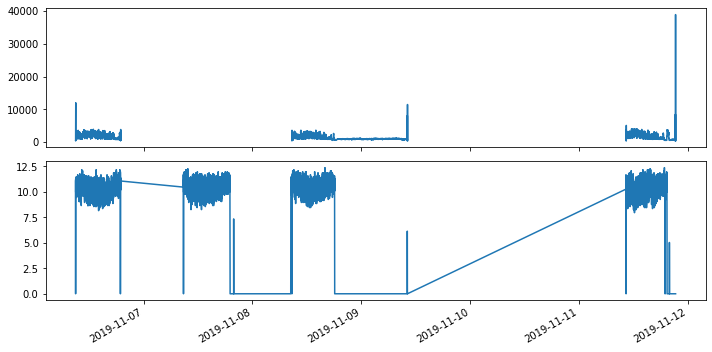

Is this an acceptable range?  n
Input Start DateTime as YYYY-mm-DD HH:MM:SS -  2019-11-06 08:55:00
Input End DateTime as YYYY-mm-DD HH:MM:SS -  2019-11-06 09:05:00


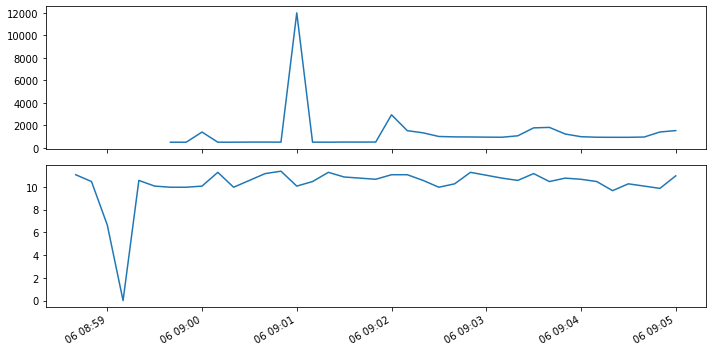

Is this an acceptable range?  y


[          Corrected_DT    EPOCH_TIME           CO2  Corrected_ET
 0  2019-11-06 08:59:40  1.573057e+09    489.356667  1.573056e+09
 1  2019-11-06 08:59:50  1.573057e+09    492.845000  1.573056e+09
 2  2019-11-06 09:00:00  1.573057e+09   1394.514000  1.573056e+09
 3  2019-11-06 09:00:10  1.573057e+09    492.140000  1.573056e+09
 4  2019-11-06 09:00:20  1.573057e+09    490.908000  1.573056e+09
 5  2019-11-06 09:00:30  1.573057e+09    500.180000  1.573056e+09
 6  2019-11-06 09:00:40  1.573057e+09    501.168000  1.573056e+09
 7  2019-11-06 09:00:50  1.573057e+09    496.456000  1.573056e+09
 8  2019-11-06 09:01:00  1.573057e+09  12007.401818  1.573056e+09
 9  2019-11-06 09:01:10  1.573057e+09    495.083000  1.573056e+09
 10 2019-11-06 09:01:20  1.573057e+09    490.992000  1.573056e+09
 11 2019-11-06 09:01:30  1.573057e+09    503.369000  1.573056e+09
 12 2019-11-06 09:01:40  1.573057e+09    502.265000  1.573056e+09
 13 2019-11-06 09:01:50  1.573057e+09    503.835000  1.573056e+09
 14 2019-1

In [28]:
plot_refinement_all([[l,'Corrected_DT','CO2'],[v,'Corrected_DT','Velocity']])